In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Colab Notebooks/explore/ai/14_16_cnn")

Mounted at /content/drive


# 手把手教你构建CNN（一）

欢迎来到智能视觉班的第一个实战编程！本次我们将用numpy库来实现卷积层和池化层，以及前向传播和反向传播。

**提示**:
- 上标 $[l]$ 表示属于第几层。 
    - 例如: $a^{[4]}$ 表示第4层的激活值。 $W^{[5]}$ 和 $b^{[5]}$ 表示第5层的参数。

- 上标 $(i)$ 表示第i个样本。 
    - 例如: $x^{(i)}$表示第i个样本的输入特征。
    
    
- 下标 $i$ 表示向量的第i个元素。
    - 例如: $a^{[l]}_i$ 表示第l层的第i个激活值。
    
    
- $n_H$, $n_W$ 和 $n_C$ 表示某一层相关矩阵的高，宽以及深度。如果你想指明第l层相关矩阵的高，宽和深度，那么你可以写成如下形式 $n_H^{[l]}$, $n_W^{[l]}$, $n_C^{[l]}$. 
- $n_{H_{prev}}$, $n_{W_{prev}}$ 和 $n_{C_{prev}}$ 表示前一层相关矩阵的高宽和深度。当然，如果你想表示l层前面一层的高宽深度，也可以写成如下形式 $n_H^{[l-1]}$, $n_W^{[l-1]}$, $n_C^{[l-1]}$。

## 1 - 导入工具库

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## 2 - 概述

在本次实战编程中我们将学会如何实现CNN相关的一些基本函数:

- 卷积相关的函数:
    - 零填补（Zero Padding）
    - 卷积窗口(Convolve window )
    - 前向卷积（Convolution forward）
    - 反向卷积（Convolution backward）
- 池化相关的函数:
    - 前向池化（Pooling forward）
    - 创建掩码（Create mask ）
    - Distribute value
    - 反向池化（Pooling backward）
    
本次实战编程我们会使用numpy库来手工实现这些函数。下一个实战编程我们会用TensorFlow，当然，TensorFlow中已经帮我们实现了这些函数，所以，下一个实战编程的重点在于调用这些函数来构建出下面的CNN。

<img width=700 src="https://z3.ax1x.com/2021/09/10/hjitOK.png">

## 3 - 卷积层

卷积层会把一个矩阵转化成另一个不同尺寸的矩阵，如下图所示 

<img width=350 src="https://z3.ax1x.com/2021/09/10/hjlVqH.png">

下面我们就来一步一步地实现卷积层。

### 3.1 - 零填补（Zero-Padding）

零填补就是往输入矩阵四周添加0,如下图所示:
<center><img width=600 height=400 src="https://z3.ax1x.com/2021/09/10/hjl4SK.png"><caption><br><b><font color='#00c752'><u> 图 1</u> : Zero-Padding</b><br>上图的padding数量为2</caption></center>

padding的作用如下:

- 它可以让我们既使用卷积层又可以避免矩阵的尺寸变得越来越小。对于很深的神经网络来说意义很大，因为如果不使用padding，那么每卷积一次矩阵尺寸就会变小，这样一来等到很深的网络层时，矩阵就没啦~ 

- 它有助于保留图像四周的信息。因为如果没有padding，那么图像四周的元素被卷积的次数就很少。

In [3]:
def zero_pad(X, pad):
    """
    给样本集X的所有样本进行零填补。
    
    参数:
    X -- 样本集，维度是(m, n_H, n_W, n_C) ,
         m表示样本的数量，这里的样本是图片数据，n_H, n_W, n_C表示图片的高，宽，深度。
    pad -- 表示padding的个数，就是我们教程里说的p的数量。
    
    返回值:
    X_pad -- 返回填补后的样本集。维度是(m, n_H + 2*pad, n_W + 2*pad, n_C),每张图片的四周都填补了pad个0
    """
    
    # np.pad是numpy提供的一个零填补函数，下面代码给X的n_H和n_W这两个维度填补pad个零。对m和n_C的维度不进行填补
    # 例如第一组(pad, pad)表示给图像的上面和下面都填补pad个零。当然，上面和下面也可以填充不同数量的零。
    X_pad = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), 'constant', constant_values=0)
    
    return X_pad

x.shape = (4, 3, 3, 2)
x_pad.shape = (4, 7, 7, 2)
x[1, 1] = [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1, 3] = [[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]
 [ 0.          0.        ]
 [ 0.          0.        ]]


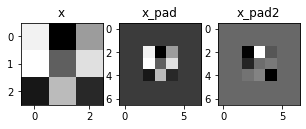

In [4]:
# 单元测试
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)
print ("x.shape =", x.shape)
print ("x_pad.shape =", x_pad.shape)
print ("x[1, 1] =", x[1, 1])
# print ("x_pad[1, 1] =", x_pad[1, 1])
print ("x_pad[1, 3] =", x_pad[1, 3])


fig, axarr = plt.subplots(1, 3)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])
axarr[2].set_title('x_pad2')
axarr[2].imshow(x_pad[2,:,:,0])

### 3.2 - 单步卷积

下面我们实现单步卷积函数。这个函数只卷积一步。后面我们将调用这个函数来完成对整个输入矩阵的卷积操作。如下图所示，卷积层会对输入矩阵进行很多步卷积。每卷积一步就会得出一个输出矩阵的元素。

<center><img width=500 src="https://z3.ax1x.com/2021/09/10/hjlXfP.gif">
<caption><br><u><font color='#00c752'><b>图 2</u>: 卷积</b><br> 上面是一个3x3的过滤器，卷积步长是1 </caption></center>

In [5]:
def conv_single_step(a_slice_prev, W, b):
    """
    这个函数只执行一步卷积
    
    参数:
    a_slice_prev -- 输入矩阵中的一小块数据，如上面的动图所示，过滤器每次只与矩阵中的一小块数据进行卷积。
                 -- 这里的输入矩阵也就是上一层的输出矩阵。维度是(f, f, n_C_prev)
    W -- 权重参数w。其实这里就是指过滤器。过滤器就是权重参数w。
      -- 维度是(f, f, n_C_prev)，与a_slice_prev是一样的。因为是它俩进行卷积，所以维度肯定是一样的。
    b -- 阈值b，教程中我们说过每一个过滤器会有一个对应的阈值。 维度是(1, 1, 1)
    
    返回值:
    Z -- 卷积一步后得到的一个数值。这个数值将是输出矩阵中的一个元素。
    """

    # 将a_slice_prev与W的每一个元素进行相乘
    s = np.multiply(a_slice_prev, W) + b
    # 将上面相乘的结果累加起来
    Z = np.sum(s)

    return Z

In [6]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = -23.16021220252078


### 3.3 - 前向传播

我们可以使用多个过滤器。每个过滤器卷积之后都会得到一个二维的矩阵。然后我们会将这些二维的矩阵叠加起来成为多维的矩阵。如下面的短视频所示。视频中有2个过滤器。

<center><video width=620 height=440 src="https://user-images.githubusercontent.com/50534516/132989026-e0da4807-bffe-454a-9a0a-2306f59be03d.mp4" type="video/mp4"/></center>


**提示**: 
1. 在python中，通过开始索引和结束索引，可以获取数组中某一区域的元素。例如，如果你想获取一个(5,5,3)矩阵中的左上角的一个2x2的子矩阵，那么你可以使用下面的代码:
```python
a_slice_prev = a_prev[0:2,0:2,:]
```
在下面的函数中，我们会用这一语法来从输入矩阵中获取一小块数据来与过滤器进行卷积。
2. 为了从矩阵中获取一个子矩阵（一小块数据），我们首先需要计算出子矩阵在母矩阵中的坐标，纵向开始索引`vert_start`, 纵向结束索引`vert_end`, 横向开始索引`horiz_start` 和横向结束索引 `horiz_end`。然后就可以用这些索引来定位一个子矩阵，如下图所示。

<center><img width=400 src="https://user-images.githubusercontent.com/50534516/132990374-55befbc1-ba6f-4fe1-b1a0-dfda5aeecf23.png">
<caption><br><u><font color='#00c752'> 图 3 </u>: 定位子矩阵 <br> </center></caption>


$$函数中还会用到如下公式来计算输出矩阵的维度:$$
$$ n_H = \lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_C = \text{这个是过滤器的个数}$$

In [7]:
def conv_forward(A_prev, W, b, hparameters):
    """
    实现卷积网络的前向传播
    
    参数:
    A_prev -- 本层的输入矩阵，也就是上一层的输出矩阵。维度是(m, n_H_prev, n_W_prev, n_C_prev)
    W -- 权重，也就是过滤器。维度是 (f, f, n_C_prev, n_C)。后面的n_C表示过滤器的个数
    b -- 阈值。维度是 (1, 1, 1, n_C)。一个过滤器配一个阈值。所以最后一维也是n_C
    hparameters -- 超参数步长s和padding数p
        
    返回值:
    Z -- 输出矩阵，也就是卷积结果。维度是(m, n_H, n_W, n_C)
    cache -- 缓存一些数值，以供反向传播时用。
    """
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    (f, f, n_C_prev, n_C) = W.shape

    stride = hparameters['stride'] # 步长s
    pad = hparameters['pad'] # 填补数量p
    
    # 计算输出矩阵的维度。参考上面提供的公式    
    n_H = int((n_H_prev - f + 2 * pad) / stride) + 1 # 使用int()来实现向下取整
    n_W = int((n_W_prev - f + 2 * pad) / stride) + 1
    
    # 初始化输出矩阵
    Z = np.zeros((m, n_H, n_W, n_C))
    
    # 给输入矩阵进行padding填补0
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):                                 # 遍历每一个样本
        a_prev_pad = A_prev_pad[i]                     # 取出一个样本对应的输入矩阵
        for h in range(n_H):                           # 遍历输出矩阵的高
            for w in range(n_W):                       # 遍历输出矩阵的宽
                for c in range(n_C):                   # 遍历每一个过滤器
                    # 计算出输入矩阵中本次应该卷积的区域的索引，然后通过这些索引取出将被卷积的小块数据。
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    # 利用之前我们实现的conv_single_step函数来对这块数据进行卷积。
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[...,c], b[...,c])
                                        
    assert(Z.shape == (m, n_H, n_W, n_C))
 
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [8]:
np.random.seed(1)
A_prev = np.random.randn(10, 4, 4, 3)
W = np.random.randn(2, 2, 3, 8)
b = np.random.randn(1, 1, 1, 8)
hparameters = {"pad" : 2,
               "stride": 1}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =", np.mean(Z))
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])

Z's mean = 0.15585932488906465
cache_conv[0][1][2][3] = [-0.20075807  0.18656139  0.41005165]


下一篇文档我们继续学习如何实现池化层和反向传播！